In [1]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

In [2]:
data_train = torchvision.datasets.MNIST('./data/', 
                                        train=True, download=True,
                                        transform=torchvision.transforms.Compose
                                        ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                        ]))
data_test = torchvision.datasets.MNIST('./data/', 
                                       train=False, download=True,
                                       transform=torchvision.transforms.Compose
                                       ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                       ]))

In [3]:
import torch

batch_size_train = 64
batch_size_test = 1000

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size=batch_size_train, 
                                                shuffle=True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size=batch_size_test, 
                                               shuffle=True)

In [4]:
examples = enumerate(data_loader_train)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data[0][0])
example_data[0][0].shape

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

torch.Size([28, 28])

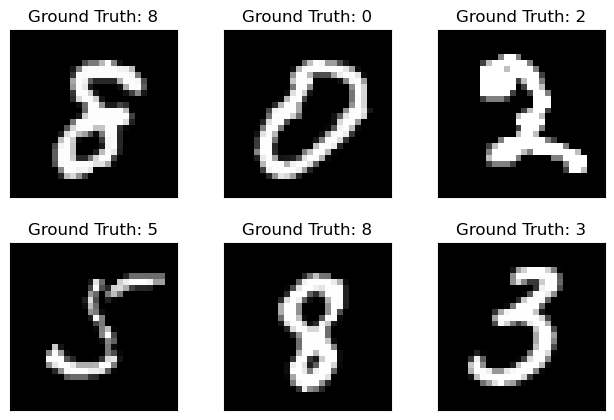

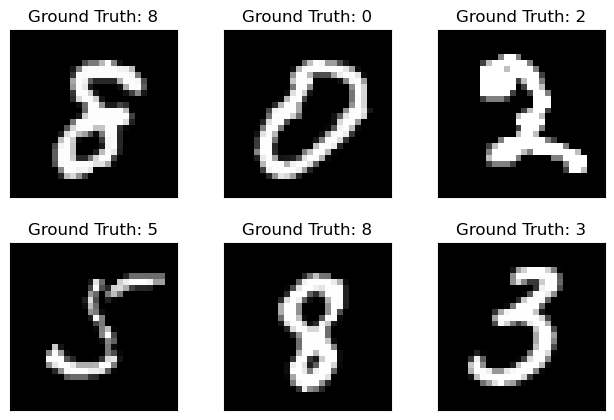

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
kernel_size=(3,3)   
kernel_number=64
input_size = 7*7*64 
weight_bit_width = 8
act_bit_width = 1
hidden1 = 64   
num_classes = 10  

In [7]:
import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Setting seeds for reproducibility
torch.manual_seed(0)

class TCV_W8A1(Module):
    def __init__(self):
        super(TCV_W8A1, self).__init__()
        
        self.input = qnn.QuantIdentity(
                         quant_type='binary',
                         scaling_impl_type='const',
                         bit_width=act_bit_width,
                         min_val=-1.0,
                         max_val=1.0, 
                         return_quant_tensor=True
                     )
        
        self.conv1 = qnn.QuantConv2d( 
                         in_channels=1,
                         out_channels=kernel_number,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn1   = nn.BatchNorm2d(kernel_number)
        self.relu1 = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        self.pool1 = qnn.QuantConv2d( 
                         in_channels=kernel_number,
                         out_channels=kernel_number,
                         kernel_size=kernel_size, 
                         stride=2, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn2   = nn.BatchNorm2d(kernel_number)
        self.relu2 = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        self.conv2 = qnn.QuantConv2d( 
                         in_channels=kernel_number,
                         out_channels=kernel_number,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn3   = nn.BatchNorm2d(kernel_number)
        self.relu3 = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        self.pool2 = qnn.QuantConv2d( 
                         in_channels=kernel_number,
                         out_channels=kernel_number,
                         kernel_size=kernel_size, 
                         stride=2, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn4   = nn.BatchNorm2d(kernel_number)
        self.relu4 = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        self.conv3 = qnn.QuantConv2d( 
                         in_channels=kernel_number,
                         out_channels=kernel_number,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn5   = nn.BatchNorm2d(kernel_number)
        self.relu5 = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        self.pool3 = qnn.QuantConv2d( 
                         in_channels=kernel_number,
                         out_channels=kernel_number,
                         kernel_size=kernel_size, 
                         stride=2, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn6   = nn.BatchNorm2d(kernel_number)
        self.relu6 = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        self.conv4 = qnn.QuantConv2d( 
                         in_channels=kernel_number,
                         out_channels=kernel_number,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn7   = nn.BatchNorm2d(kernel_number)
        self.relu7 = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        self.pool4 = qnn.QuantConv2d( 
                         in_channels=kernel_number,
                         out_channels=kernel_number,
                         kernel_size=kernel_size, 
                         stride=2, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn8   = nn.BatchNorm2d(kernel_number)
        self.relu8 = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        self.pool5 = qnn.QuantConv2d( 
                         in_channels=kernel_number,
                         out_channels=9,
                         kernel_size=kernel_size, 
                         stride=2, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn9   = nn.BatchNorm2d(9)
        self.relu9 = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        self.out   = qnn.QuantLinear(
                         9, 
                         num_classes, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )

    def forward(self, x):
        out = self.input(x)
        #print("Input Shape: ",out.shape)
        out = self.relu1(self.bn1(self.conv1(out)))
        #print("1st CONV Shape: ",out.shape)
        out = self.relu2(self.bn2(self.pool1(out)))
        #print("1st POOL Shape: ",out.shape)
        out = self.relu3(self.bn3(self.conv2(out)))
        #print("2nd CONV Shape: ",out.shape)
        out = self.relu4(self.bn4(self.pool2(out)))
        #print("2nd POOL Shape: ",out.shape)
        out = self.relu5(self.bn5(self.conv3(out)))
        #print("3rd CONV Shape: ",out.shape)
        out = self.relu6(self.bn6(self.pool3(out)))
        #print("3rd POOL Shape: ",out.shape)
        out = self.relu7(self.bn7(self.conv4(out)))
        #print("4th CONV Shape: ",out.shape)
        out = self.relu8(self.bn8(self.pool4(out)))
        #print("4th POOL Shape: ",out.shape)
        out = self.relu9(self.bn9(self.pool5(out)))
        #print("5th POOL Shape: ",out.shape)
        out = out.reshape(out.shape[0], -1)
        #print("Flattern Shape: ",out.shape)
        out = self.out(out)
        #print("Output Shape: ",out.shape)
        return out
   
model = TCV_W8A1()

In [8]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        #inputs, target = inputs.cuda(), target.cuda()
        inputs, target = Variable(inputs), Variable(target)
        
        outputs = model(inputs)
        _,pred = torch.max(outputs.data,1)
        
        optimizer.zero_grad()
        loss = criterion(outputs,target)
 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.numpy()) 
           
    return losses

In [9]:
import torch
from sklearn.metrics import accuracy_score

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            #inputs, target = inputs.cuda(), target.cuda()
            inputs, target = Variable(inputs),Variable(target)
            output = model(inputs)
            #output = torch.sigmoid(output_orig)  
            _,pred = torch.max(output,1)
            # compare against a threshold of 0.5 to generate 0/1
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [10]:
num_epochs = 10
learn_rate = 0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [11]:
# loss criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, betas=(0.9, 0.999))

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        test_acc = test(model, data_loader_test)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)

Training loss = 2.299617 test accuracy = 0.110600:  10%| | 1/10 [04:53<44:04, 29

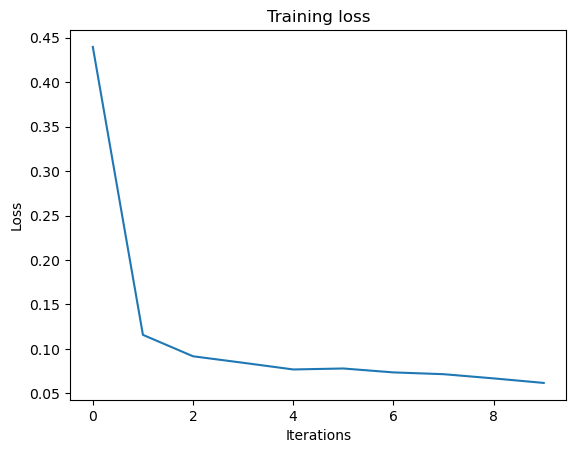

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

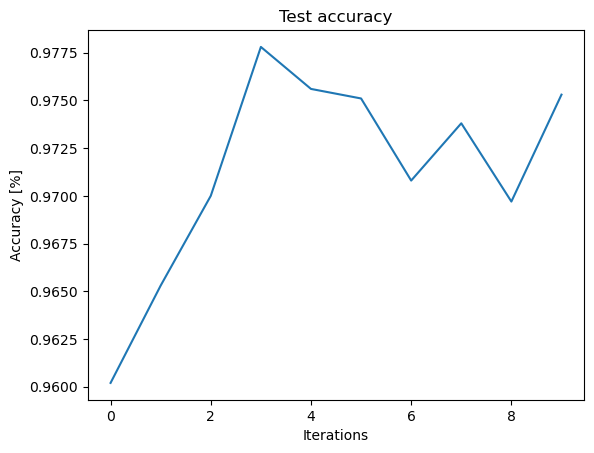

In [14]:
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

In [15]:
test(model, data_loader_test)

0.9753

In [16]:
torch.save(model.state_dict(), "./model/torch/cnn_w8a1_nopool.pth")

In [9]:
import brevitas.onnx as bo
from brevitas.quant_tensor import QuantTensor

ready_model_filename = "./model/onnx/brevitas/brevitas_cnn_w8a1_nopool.onnx"
input_shape = (1, 1, 28, 28)

#Move to CPU before export
model.cpu()

# Export to ONNX
bo.export_finn_onnx(
#    model, export_path=ready_model_filename, input_t=input_qt,
    model, export_path=ready_model_filename, input_shape=input_shape,
                     export_params=True, do_constant_folding=True,
                     input_names=['input'], output_names=['output']
)

print("Model saved to %s" % ready_model_filename)

Input Shape:  torch.Size([1, 1, 28, 28])
1st CONV Shape:  torch.Size([1, 64, 28, 28])
1st POOL Shape:  torch.Size([1, 64, 14, 14])
2nd CONV Shape:  torch.Size([1, 64, 14, 14])
2nd POOL Shape:  torch.Size([1, 64, 7, 7])
3rd CONV Shape:  torch.Size([1, 64, 7, 7])
3rd POOL Shape:  torch.Size([1, 64, 4, 4])
4th CONV Shape:  torch.Size([1, 64, 4, 4])
4th POOL Shape:  torch.Size([1, 64, 2, 2])
5th POOL Shape:  torch.Size([1, 9, 1, 1])
Flattern Shape:  torch.Size([1, 9])
Output Shape:  torch.Size([1, 10])
Input Shape:  torch.Size([1, 1, 28, 28])
1st CONV Shape:  torch.Size([1, 64, 28, 28])
1st POOL Shape:  torch.Size([1, 64, 14, 14])
2nd CONV Shape:  torch.Size([1, 64, 14, 14])
2nd POOL Shape:  torch.Size([1, 64, 7, 7])
3rd CONV Shape:  torch.Size([1, 64, 7, 7])
3rd POOL Shape:  torch.Size([1, 64, 4, 4])
4th CONV Shape:  torch.Size([1, 64, 4, 4])
4th POOL Shape:  torch.Size([1, 64, 2, 2])
5th POOL Shape:  torch.Size([1, 9, 1, 1])
Flattern Shape:  torch.Size([1, 9])
Output Shape:  torch.Size([

[W shape_type_inference.cpp:1920] Warning: The shape inference of finn.custom_op.general::MultiThreshold type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)


In [18]:
from finn.util.visualization import showInNetron

showInNetron(ready_model_filename)

Serving './model/onnx/brevitas/brevitas_tcv_w1a1.onnx' at http://0.0.0.0:8081
